# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import pycountry_convert as pc
import matplotlib.pyplot as plt
import folium
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Import Weather Data

In [6]:
client = bigquery.Client()
dataset_ref = client.dataset("noaa_gsod", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

tables = list(client.list_tables(dataset))

table_ref = dataset_ref.table("stations")
table = client.get_table(table_ref)
stations_df = client.list_rows(table).to_dataframe()

table_ref = dataset_ref.table("gsod2020")
table = client.get_table(table_ref)
twenty_twenty_df = client.list_rows(table).to_dataframe()

stations_df['STN'] = stations_df['usaf'] + '-' + stations_df['wban']
twenty_twenty_df['STN'] = twenty_twenty_df['stn'] + '-' + twenty_twenty_df['wban']

cols_1 = ['STN', 'mo', 'da', 'temp', 'min', 'max', 'stp', 'slp', 'dewp', 'wdsp', 'prcp', 'fog']
cols_2 = ['STN', 'country', 'state', 'call', 'lat', 'lon', 'elev']
weather_df = twenty_twenty_df[cols_1].join(stations_df[cols_2].set_index('STN'), on='STN')

weather_df['temp'] = weather_df['temp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['max'] = weather_df['max'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['min'] = weather_df['min'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['stp'] = weather_df['stp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['slp'] = weather_df['slp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['dewp'] = weather_df['dewp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['wdsp'] = weather_df['wdsp'].apply(lambda x: np.nan if x==999.9 else x)
weather_df['prcp'] = weather_df['prcp'].apply(lambda x: np.nan if x==99.9 else x)

display(weather_df.tail(10))
weather_df.info(verbose=True)

## Loading COVID-19 Dataset

In [297]:
covid=pd.read_csv("MasterProjectDatasets/covid_19_data.csv")
covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.000000,0.000000,0.000000
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.000000,0.000000,0.000000
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.000000,0.000000,0.000000
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.000000,0.000000,0.000000
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.000000,0.000000,0.000000


In [298]:
covid.dtypes

SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object

In [299]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)


Size/Shape of the dataset:  (81925, 8)
Checking for null values:
 SNo                    0
ObservationDate        0
Province/State     27457
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64
Checking Data-type of each column:
 SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


## Date Pre-processing

In [300]:
#Dropping column as SNo is of no use, and "Province/State" contains too many missing values
covid.drop(["SNo"],1,inplace=True)

In [301]:
#Converting "Observation Date" into Datetime format
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])

In [302]:
covid

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.000000,0.000000,0.000000
1,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.000000,0.000000,0.000000
2,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.000000,0.000000,0.000000
3,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.000000,0.000000,0.000000
4,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
81920,2020-08-07,Zaporizhia Oblast,Ukraine,2020-08-08 04:34:53,895.000000,21.000000,640.000000
81921,2020-08-07,Zeeland,Netherlands,2020-08-08 04:34:53,905.000000,69.000000,0.000000
81922,2020-08-07,Zhejiang,Mainland China,2020-08-08 04:34:53,1271.000000,1.000000,1268.000000
81923,2020-08-07,Zhytomyr Oblast,Ukraine,2020-08-08 04:34:53,2064.000000,40.000000,1518.000000


In [303]:
covid = covid[covid["ObservationDate"] <= '07/01/2020']

In [304]:
duplicateDFRow = covid[covid.duplicated()]

In [305]:
duplicateDFRow

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered


In [310]:
covid['Date'] = covid["ObservationDate"]

C:\Users\z0042f9s\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [311]:
grouped_country=covid.groupby(["Country/Region","ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [312]:
grouped_date=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

In [314]:
grouped_date["Active"]=grouped_date["Confirmed"]-grouped_date["Recovered"]-grouped_date["Deaths"]
grouped_date["Closed"] = grouped_date["Recovered"]+grouped_date["Deaths"]
grouped_date["Mortality Rate"]=(grouped_date["Deaths"]/grouped_date["Confirmed"])*100
grouped_date["Recovery Rate"]=(grouped_date["Recovered"]/grouped_date["Confirmed"])*100

In [321]:
grouped_date.shape

(162, 7)

### Correlation Analysis 

In [322]:
grouped_date[grouped_date.columns[0:7]].corr(method ='pearson').style.background_gradient(cmap='Reds')

,Recovered,Deaths,Active,Closed,Mortality Rate,Recovery Rate
Recovered,1.000000,0.951140,0.949783,0.999498,0.425446,0.600839
Deaths,0.951140,1.000000,0.997314,0.960444,0.651756,0.578309
Active,0.949783,0.997314,1.000000,0.958944,0.671214,0.567534
Closed,0.999498,0.960444,0.958944,1.000000,0.450586,0.601238
Mortality Rate,0.425446,0.651756,0.671214,0.450586,1.000000,0.387097
Recovery Rate,0.600839,0.578309,0.567534,0.601238,0.387097,1.000000


### Feature Engineering

In [153]:
grouped_date["Days Since"]=grouped_date.index-grouped_date.index[0]
grouped_date["Days Since"] = grouped_date["Days Since"].dt.days

In [154]:
grouped_country["Active"]=grouped_country["Confirmed"]-grouped_country["Recovered"]-grouped_country["Deaths"]
grouped_country["log_confirmed"]=np.log(grouped_country["Confirmed"])
grouped_country["log_active"]=np.log(grouped_country["Active"])

C:\Users\z0042f9s\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\pandas\core\series.py:726: RuntimeWarning:

divide by zero encountered in log



In [158]:
grouped_date["Mortality Rate"]=(grouped_date["Deaths"]/grouped_date["Confirmed"])*100
grouped_date["Recovery Rate"]=(grouped_date["Recovered"]/grouped_date["Confirmed"])*100

In [159]:
grouped_date['year']=grouped_date.index.year 
grouped_date['month']=grouped_date.index.month 
grouped_date['day']=grouped_date.index.day
grouped_date['dayofweek_num']=grouped_date.index.dayofweek  

In [160]:
grouped_date['DailyCases'] = grouped_date['Confirmed'].diff().fillna(0)
grouped_date['DailyDeaths'] = grouped_date['Deaths'].diff().fillna(0)
grouped_date['DailyRecovered'] = grouped_date['Recovered'].diff().fillna(0)

In [161]:
grouped_date = grouped_date.iloc[1:]

In [162]:
grouped_date["Confirmed GF"]=(grouped_date["Confirmed"]/grouped_date["Confirmed"].shift()).fillna(1)
grouped_date["Deaths GF"]=(grouped_date["Deaths"]/grouped_date["Deaths"].shift()).fillna(1)
grouped_date["Recovered GF"]=(grouped_date["Recovered"]/grouped_date["Recovered"].shift()).fillna(1)
grouped_date["Active GF"]=(grouped_date["Active"]/grouped_date["Active"].shift()).fillna(1)
grouped_date["Closed GF"]=(grouped_date["Closed"]/grouped_date["Closed"].shift()).fillna(1)


C:\Users\z0042f9s\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\z0042f9s\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\z0042f9s\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice 

In [167]:
grouped_date['lag_1'] = grouped_date['Confirmed'].shift(1)

C:\Users\z0042f9s\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [169]:
grouped_date = grouped_date.iloc[1:]

### Feature Scaling

In [170]:
from sklearn.preprocessing import MinMaxScaler

In [175]:
scale = MinMaxScaler().fit_transform(grouped_date)
df_scalednormalization = pd.DataFrame(MinMaxScaler().fit_transform(grouped_date),columns = grouped_date.columns)

In [176]:
df_scalednormalization.describe()

,Confirmed,Recovered,Deaths,Days Since,Active,Closed,Mortality Rate,Recovery Rate,year,month,...,dayofweek_num,DailyCases,DailyDeaths,DailyRecovered,Confirmed GF,Deaths GF,Recovered GF,Active GF,Closed GF,lag_1
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,...,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,0.278195,0.221821,0.338736,0.500000,0.338855,0.231724,0.559827,0.568660,0.000000,0.480208,...,0.500000,0.307434,0.307565,0.155329,0.068904,0.111327,0.095705,0.112288,0.103446,0.277591
std,0.298749,0.279936,0.343396,0.291397,0.324595,0.284026,0.320066,0.281322,0.000000,0.256551,...,0.335423,0.253898,0.248928,0.173634,0.121951,0.160807,0.148781,0.122472,0.148201,0.300049
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.008756,0.009036,0.006208,0.250000,0.011747,0.008796,0.268225,0.381526,0.000000,0.333333,...,0.166667,0.016561,0.013355,0.010788,0.015731,0.018431,0.021206,0.059369,0.021759,0.008740
50%,0.175938,0.078017,0.226197,0.500000,0.288291,0.090569,0.622115,0.589439,0.000000,0.500000,...,0.500000,0.347453,0.350854,0.109808,0.022818,0.044844,0.039938,0.067494,0.045381,0.172641
75%,0.489614,0.371212,0.656972,0.750000,0.613546,0.395418,0.845957,0.807444,0.000000,0.666667,...,0.833333,0.459359,0.499070,0.245762,0.079110,0.160762,0.094089,0.130893,0.107024,0.489621
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:title={'center':'Correlation with confirmed variable'}>

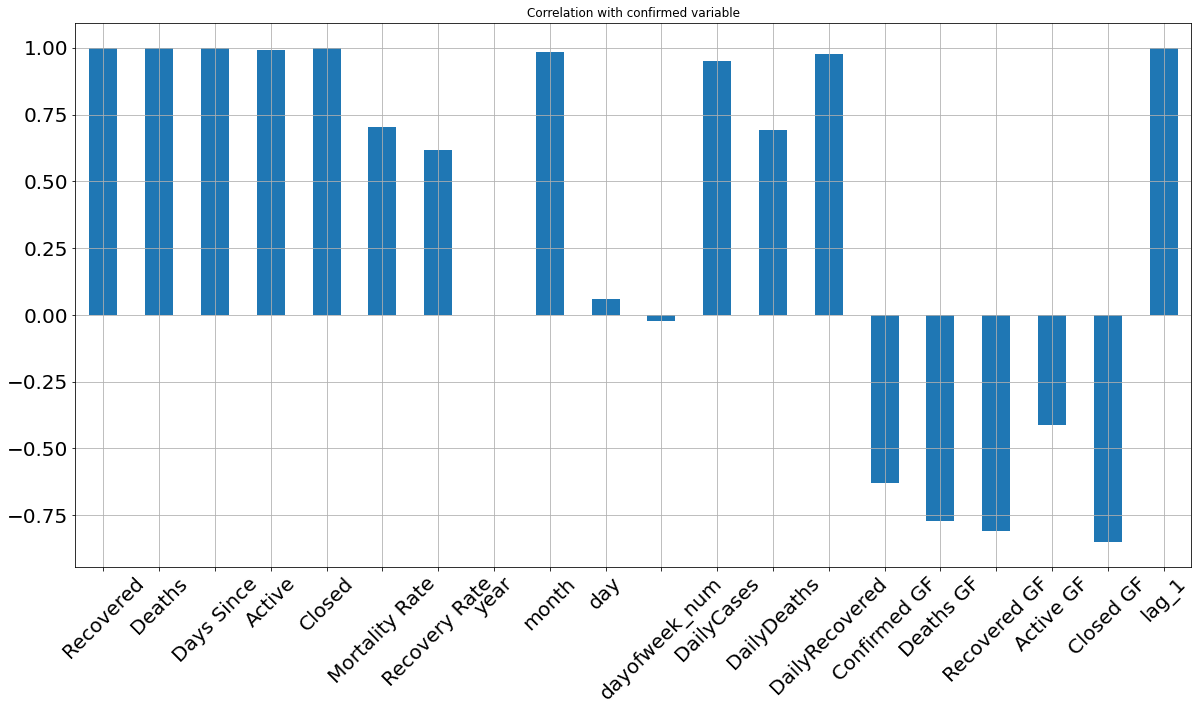

In [182]:
df_scalednormalization.loc[:, df_scalednormalization.columns != 'Confirmed'].corrwith(df_scaledstandardization.Confirmed,method='spearman').plot.bar(
        figsize = (20, 10), title = "Correlation with confirmed variable", fontsize = 20,
        rot = 45, grid = True)

## Machine Learning Models

In [191]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(finalDf.iloc[:,:7], finalDf.iloc[:,7:], test_size=0.20, shuffle=False) 

### Train-test split

In [194]:
train_ml=grouped_date.iloc[:int(grouped_date.shape[0]*0.80)]
valid_ml=grouped_date.iloc[int(grouped_date.shape[0]*0.80):]
model_scores=[]

In [195]:
lin_reg=LinearRegression(normalize=True)

In [196]:
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))

LinearRegression(normalize=True)

In [197]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))


In [198]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
model_scores.append(np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mean Absolute Error for Linear Regression: ",mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg))

Root Mean Square Error for Linear Regression:  2927758.2996494365
Mean Absolute Error for Linear Regression:  2784309.7951897546


In [274]:
import plotly.graph_objects as go
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(grouped_date["Days Since"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=grouped_date.index, y=grouped_date["Confirmed"],
                    mode='lines+markers',name="Confirmed Cases"))
fig.add_trace(go.Scatter(x=grouped_date.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [200]:
train_ml=grouped_date.iloc[:int(grouped_date.shape[0]*0.80)]
valid_ml=grouped_date.iloc[int(grouped_date.shape[0]*0.80):]

In [201]:
#Optimizing the polynomial degree value 
k_values_with_rmse = {}
for i in range(1,16):
    poly = PolynomialFeatures(degree = i)
    train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
    valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
    y=train_ml["Confirmed"]
    linreg=LinearRegression(normalize=True)
    linreg.fit(train_poly,y)
    prediction_poly=linreg.predict(valid_poly)
    rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
    mae_poly=mean_absolute_error(valid_ml["Confirmed"],prediction_poly)
    k_values_with_rmse[i] = rmse_poly
    
print("Best Polynomial Degree value :",min(k_values_with_rmse.items(), key=lambda x: x[1]) )

Best Polynomial Degree value : (5, 179205.83278377922)


In [202]:
k_values_with_rmse

{1: 2927758.2996494346,
 2: 210875.1327406306,
 3: 195193.26161054155,
 4: 2566188.037653309,
 5: 179205.83278377922,
 6: 6555512.831632831,
 7: 724539.3371012986,
 8: 17308910.27153727,
 9: 5802017.852138789,
 10: 59526264.58512694,
 11: 2492888.5807213904,
 12: 145469821.62786704,
 13: 239095990.95431778,
 14: 1125532862.1248922,
 15: 82629615.09575501}

In [203]:
min(k_values_with_rmse.items(), key=lambda x: x[1]) 

(5, 179205.83278377922)

In [204]:
poly = PolynomialFeatures(degree = 5)
train_poly=poly.fit_transform(np.array(train_ml["Days Since"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days Since"]).reshape(-1,1))
y=train_ml["Confirmed"]

In [205]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(normalize=True)

In [206]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_poly))
mae_poly=mean_absolute_error(valid_ml["Confirmed"],prediction_poly)
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)
print("Mean Absolute Error for Linear Regression:: ",mae_poly)

Root Mean Squared Error for Polynomial Regression:  179205.83278377922
Mean Absolute Error for Linear Regression::  168300.684702334


In [275]:
comp_data=poly.fit_transform(np.array(grouped_date["Days Since"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=grouped_date.index, y=grouped_date["Confirmed"],
                    mode='lines+markers',name="Confirmed Cases"))
fig.add_trace(go.Scatter(x=grouped_date.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='black', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

In [208]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(grouped_date["Days Since"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [210]:
from datetime import timedelta
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(grouped_date.index[-1]+timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(grouped_date["Days Since"].max()+i).reshape(-1,1))[0][0])

In [212]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction"])
model_predictions.head(7)

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction
0,2020-07-02,6229231.465216,11032003.056675
1,2020-07-03,6276570.541605,11292228.916467
2,2020-07-04,6323909.617993,11562825.172132
3,2020-07-05,6371248.694381,11844241.636182
4,2020-07-06,6418587.770769,12136940.279166
5,2020-07-07,6465926.847158,12441395.374741
6,2020-07-08,6513265.923546,12758093.644755


In [292]:
model_train=grouped_date.iloc[:int(grouped_date.shape[0]*0.80)]
valid=grouped_date.iloc[int(grouped_date.shape[0]*0.80):]
y_pred=valid.copy()

In [293]:
#Training and opimiztizing ARIMA MODEL
model_arima= auto_arima(model_train["Confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2618.306, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2617.321, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=2617.469, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=2620.445, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2618.034, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2622.405, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=2620.044, Time=0.08 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=2618.632, Time=0.21 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2617.905, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2619.049, Time=0.11 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=2620.301, Time=0.36 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=2609.196, Time=0.29 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2618.315, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2618.458, Time=0.11 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=2621.031, Time=0.21 sec
Total fit 

ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True)

In [294]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [295]:
model_scores.append(np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(valid["Confirmed"],prediction_arima)))
print("Mean Absolute Error for ARIMA Model: ",mean_absolute_error(valid["Confirmed"],prediction_arima))

Root Mean Square Error for ARIMA Model:  453372.6114293843
Mean Absolute Error for ARIMA Model:  390950.1529277003


In [296]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [218]:
ARIMA_model_new_prediction=[]
for i in range(1,18):
    ARIMA_model_new_prediction.append(model_arima.predict(len(valid)+i)[-1])
model_predictions["ARIMA Model Prediction"]=ARIMA_model_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,ARIMA Model Prediction
0,2020-07-02,6229231.465216,11032003.056675,11654647.939294
1,2020-07-03,6276570.541605,11292228.916467,11866279.495287
2,2020-07-04,6323909.617993,11562825.172132,12079702.552536
3,2020-07-05,6371248.694381,11844241.636182,12295582.430692
4,2020-07-06,6418587.770769,12136940.279166,12514569.073950


In [219]:
from fbprophet import Prophet

In [237]:
prophet_c=Prophet(interval_width=0.80,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(grouped_date.index),list(grouped_date["Confirmed"])),columns=['ds','y'])

In [238]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [239]:
forecast_c=prophet_c.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [240]:
confirmed_forecast=prophet_c.predict(forecast_c)

In [241]:
model_scores.append(np.sqrt(mean_squared_error(grouped_date["Confirmed"],confirmed_forecast['yhat'].head(grouped_date.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(grouped_date["Confirmed"],confirmed_forecast['yhat'].head(grouped_date.shape[0]))))

print("Mean Absolute Error for Prophet Model: ",mean_absolute_error(grouped_date["Confirmed"],confirmed_forecast['yhat'].head(grouped_date.shape[0])))

Root Mean Squared Error for Prophet Model:  49845.61345059566
Mean Absolute Error for Prophet Model:  26565.94091806921


In [278]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["Confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=grouped_date.index, y=confirmed_forecast['yhat'],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Prophet Model",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Text(0.5, 1.0, 'Confirmed Cases Prophet Model Traning')

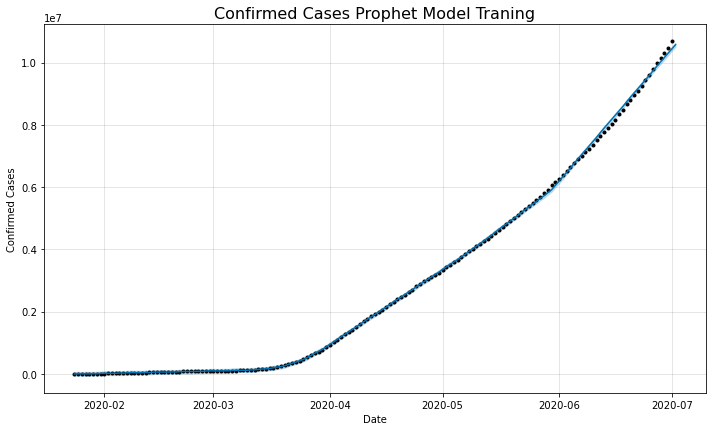

In [247]:

fig = prophet_c.plot(confirmed_forecast,xlabel='Date',ylabel='Confirmed Cases')
ax = fig.gca()
ax.set_title("Confirmed Cases Prophet Model Traning", size=16)

Figure(648x432)


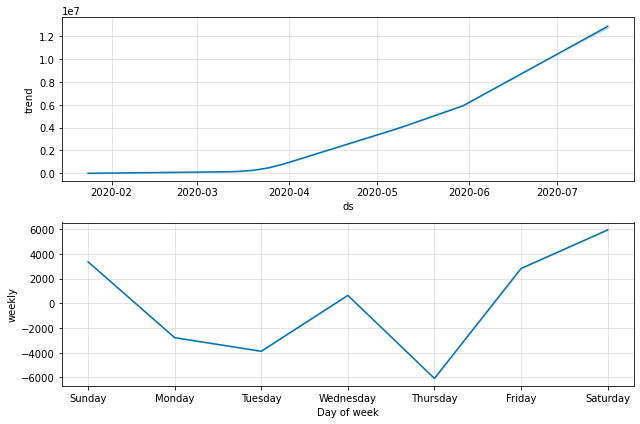

In [226]:
print(prophet_c.plot_components(confirmed_forecast))

In [227]:
model_predictions["Prophet's Prediction"]=list(confirmed_forecast["yhat"].tail(17))

In [228]:
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,ARIMA Model Prediction,Prophet's Prediction
0,2020-07-02,6229231.465216,11032003.056675,11654647.939294,10579437.919264
1,2020-07-03,6276570.541605,11292228.916467,11866279.495287,10730052.770847
2,2020-07-04,6323909.617993,11562825.172132,12079702.552536,10874897.279790
3,2020-07-05,6371248.694381,11844241.636182,12295582.430692,11014040.083315
4,2020-07-06,6418587.770769,12136940.279166,12514569.073950,11149632.520096


# Data Analysis

In [33]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise["Days Since"]=datewise.index-datewise.index.min()

In [34]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases around the World: ",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases around the World: ",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases around the World: ",datewise["Deaths"].iloc[-1])
print("Total number of Active Cases around the World: ",(datewise["Confirmed"].iloc[-1]-datewise["Recovered"].iloc[-1]-datewise["Deaths"].iloc[-1]))
print("Total number of Closed Cases around the World: ",datewise["Recovered"].iloc[-1]+datewise["Deaths"].iloc[-1])
print("Approximate number of Confirmed Cases per Day around the World: ",np.round(datewise["Confirmed"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Recovered Cases per Day around the World: ",np.round(datewise["Recovered"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Death Cases per Day around the World: ",np.round(datewise["Deaths"].iloc[-1]/datewise.shape[0]))
print("Approximate number of Confirmed Cases per hour around the World: ",np.round(datewise["Confirmed"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Recovered Cases per hour around the World: ",np.round(datewise["Recovered"].iloc[-1]/((datewise.shape[0])*24)))
print("Approximate number of Death Cases per hour around the World: ",np.round(datewise["Deaths"].iloc[-1]/((datewise.shape[0])*24)))
print("Number of Confirmed Cases in last 24 hours: ",datewise["Confirmed"].iloc[-1]-datewise["Confirmed"].iloc[-2])
print("Number of Recovered Cases in last 24 hours: ",datewise["Recovered"].iloc[-1]-datewise["Recovered"].iloc[-2])
print("Number of Death Cases in last 24 hours: ",datewise["Deaths"].iloc[-1]-datewise["Deaths"].iloc[-2])

Basic Information
Totol number of countries with Disease Spread:  223
Total number of Confirmed Cases around the World:  10692551.0
Total number of Recovered Cases around the World:  5577684.0
Total number of Deaths Cases around the World:  516210.0
Total number of Active Cases around the World:  4598657.0
Total number of Closed Cases around the World:  6093894.0
Approximate number of Confirmed Cases per Day around the World:  66003.0
Approximate number of Recovered Cases per Day around the World:  34430.0
Approximate number of Death Cases per Day around the World:  3186.0
Approximate number of Confirmed Cases per hour around the World:  2750.0
Approximate number of Recovered Cases per hour around the World:  1435.0
Approximate number of Death Cases per hour around the World:  133.0
Number of Confirmed Cases in last 24 hours:  216713.0
Number of Recovered Cases in last 24 hours:  224412.0
Number of Death Cases in last 24 hours:  4957.0


In [35]:
# pip install plotly

In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
fig=px.bar(x=datewise.index,y=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Active Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases",)
fig.show()

In [37]:
fig=px.bar(x=datewise.index,y=datewise["Recovered"]+datewise["Deaths"])
fig.update_layout(title="Distribution of Number of Closed Cases",
                  xaxis_title="Date",yaxis_title="Number of Cases")
fig.show()

In [38]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num.append(w)
    w=w+1

In [40]:
datewise["WeekOfYear"]=datewise.index.weekofyear

week_num=[]
weekwise_confirmed=[]
weekwise_recovered=[]
weekwise_deaths=[]
w=1
for i in list(datewise["WeekOfYear"].unique()):
    weekwise_confirmed.append(datewise[datewise["WeekOfYear"]==i]["Confirmed"].iloc[-1])
    weekwise_recovered.append(datewise[datewise["WeekOfYear"]==i]["Recovered"].iloc[-1])
    weekwise_deaths.append(datewise[datewise["WeekOfYear"]==i]["Deaths"].iloc[-1])
    week_num.append(w)
    w=w+1

fig=go.Figure()
fig.add_trace(go.Scatter(x=week_num, y=weekwise_confirmed,
                    mode='lines+markers',
                    name='Weekly Growth of Confirmed Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_recovered,
                    mode='lines+markers',
                    name='Weekly Growth of Recovered Cases'))
fig.add_trace(go.Scatter(x=week_num, y=weekwise_deaths,
                    mode='lines+markers',
                    name='Weekly Growth of Death Cases'))
fig.update_layout(title="Weekly Growth",
                 xaxis_title="Week Number",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Text(0.5, 1.0, 'Weekly increase in Number of Death Cases')

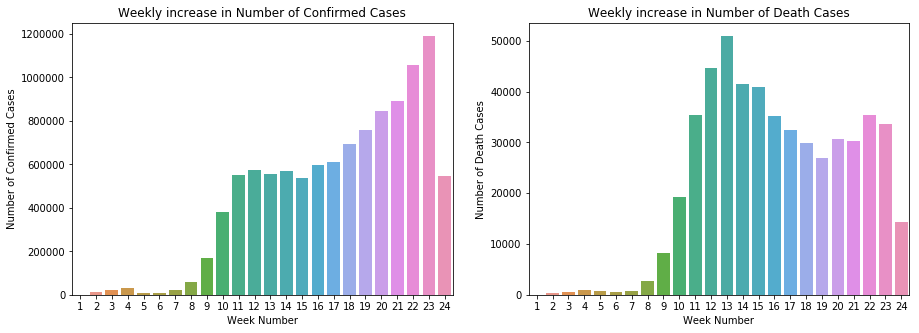

In [41]:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.barplot(x=week_num,y=pd.Series(weekwise_confirmed).diff().fillna(0),ax=ax1)
sns.barplot(x=week_num,y=pd.Series(weekwise_deaths).diff().fillna(0),ax=ax2)
ax1.set_xlabel("Week Number")
ax2.set_xlabel("Week Number")
ax1.set_ylabel("Number of Confirmed Cases")
ax2.set_ylabel("Number of Death Cases")
ax1.set_title("Weekly increase in Number of Confirmed Cases")
ax2.set_title("Weekly increase in Number of Death Cases")

In [42]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"],
                    mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"],
                    mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"],
                    mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Growth of different types of cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [43]:
#Calculating the Mortality Rate and Recovery Rate
datewise["Mortality Rate"]=(datewise["Deaths"]/datewise["Confirmed"])*100
datewise["Recovery Rate"]=(datewise["Recovered"]/datewise["Confirmed"])*100
datewise["Active Cases"]=datewise["Confirmed"]-datewise["Recovered"]-datewise["Deaths"]
datewise["Closed Cases"]=datewise["Recovered"]+datewise["Deaths"]

print("Average Mortality Rate",datewise["Mortality Rate"].mean())
print("Median Mortality Rate",datewise["Mortality Rate"].median())
print("Average Recovery Rate",datewise["Recovery Rate"].mean())
print("Median Recovery Rate",datewise["Recovery Rate"].median())

#Plotting Mortality and Recovery Rate 
fig = make_subplots(rows=2, cols=1,
                   subplot_titles=("Recovery Rate", "Mortatlity Rate"))
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Recovered"]/datewise["Confirmed"])*100,name="Recovery Rate"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=datewise.index, y=(datewise["Deaths"]/datewise["Confirmed"])*100,name="Mortality Rate"),
    row=2, col=1
)
fig.update_layout(height=1000,legend=dict(x=-0.1,y=1.2,traceorder="normal"))
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Recovery Rate", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2)
fig.update_yaxes(title_text="Mortality Rate", row=1, col=2)
fig.show()

Average Mortality Rate 4.885377599228892
Median Mortality Rate 5.209104675371188
Average Recovery Rate 31.835587938769972
Median Recovery Rate 32.94734334002261


In [44]:
print("Average increase in number of Confirmed Cases every day: ",np.round(datewise["Confirmed"].diff().fillna(0).mean()))
print("Average increase in number of Recovered Cases every day: ",np.round(datewise["Recovered"].diff().fillna(0).mean()))
print("Average increase in number of Deaths Cases every day: ",np.round(datewise["Deaths"].diff().fillna(0).mean()))

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().fillna(0),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().fillna(0),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().fillna(0),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="Daily increase in different types of Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

Average increase in number of Confirmed Cases every day:  66000.0
Average increase in number of Recovered Cases every day:  34430.0
Average increase in number of Deaths Cases every day:  3186.0


In [45]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Confirmed"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Confirmed Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Recovered"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Recovered Cases'))
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["Deaths"].diff().rolling(window=7).mean(),mode='lines+markers',
                    name='Death Cases'))
fig.update_layout(title="7 Days Rolling Mean of Daily Increase of Confirmed, Recovered and Death Cases",
                 xaxis_title="Date",yaxis_title="Number of Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()